## Librairies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

from xgboost import XGBRegressor

In [ ]:
sns.set_theme()

## Load dataset

Data source: [Seoul Bike Sharing Demand Data Set](https://archive.ics.uci.edu/ml/datasets/Seoul+Bike+Sharing+Demand)

In [ ]:
dataset = pd.read_csv("SeoulBikeData.csv", encoding="latin-1")
dataset.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [ ]:
dataset.shape

(8760, 14)

Here we change the name of the variables

In [ ]:
BASE_COLUMNS = ['Date', 'Rented Bike Count', 'Hour', 'Temperature', 'Humidity',
       'Wind speed', 'Visibility', 'Dew point temperature',
       'Solar Radiation', 'Rainfall', 'Snowfall', 'Seasons',
       'Holiday', 'Functioning Day']

In [ ]:
dataset.columns = BASE_COLUMNS

And here we change the order of the variables

In [ ]:
NEW_COLUMNS = ['Date', 'Hour', 'Temperature', 'Dew point temperature', 
       'Wind speed', 'Humidity', 'Visibility',
       'Solar Radiation', 'Rainfall', 'Snowfall', 'Seasons',
       'Holiday', 'Functioning Day', 'Rented Bike Count']

In [ ]:
dataset = dataset.reindex(NEW_COLUMNS, axis=1)
dataset.head()

,Date,Hour,Temperature,Dew point temperature,Wind speed,Humidity,Visibility,Solar Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning Day,Rented Bike Count
0,01/12/2017,0,-5.2,-17.6,2.2,37,2000,0.0,0.0,0.0,Winter,No Holiday,Yes,254
1,01/12/2017,1,-5.5,-17.6,0.8,38,2000,0.0,0.0,0.0,Winter,No Holiday,Yes,204
2,01/12/2017,2,-6.0,-17.7,1.0,39,2000,0.0,0.0,0.0,Winter,No Holiday,Yes,173
3,01/12/2017,3,-6.2,-17.6,0.9,40,2000,0.0,0.0,0.0,Winter,No Holiday,Yes,107
4,01/12/2017,4,-6.0,-18.6,2.3,36,2000,0.0,0.0,0.0,Winter,No Holiday,Yes,78


The dataset ```pollution_O3_dataset.csv``` has been created by retrieving the daily O3 pollution in Seoul, using the ```Measurement_summary.csv``` dataset. The molecule O3 has revealed to have the most correlation with ```Rented Bike Count``` then the other pollution molecules provided in the measurement dataset.

Data source: [Seoul's daily pollution](https://www.kaggle.com/mihirhalai/seoul-s-daily-pollution/data)

In [ ]:
pollution = pd.read_csv("pollution_O3_dataset.csv")
pollution["Measurement date"] = pollution["Measurement date"].apply(lambda x: x.replace("-", "/"))
pollution["Measurement date"] = pollution["Measurement date"].apply(lambda x: "/".join(x.split("/")[::-1]))
pollution.head()

,Measurement date,O3
0,01/12/2017,0.011667
1,02/12/2017,0.004500
2,03/12/2017,0.004625
3,04/12/2017,0.017625
4,05/12/2017,0.017667


In [ ]:
pollution_dict = pollution.set_index("Measurement date").to_dict()["O3"]

## Variables Exploration

In [ ]:
dataset["Hour"].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [ ]:
dataset["Seasons"].unique()

array(['Winter', 'Spring', 'Summer', 'Autumn'], dtype=object)

In [ ]:
dataset["Holiday"].unique()

array(['No Holiday', 'Holiday'], dtype=object)

In [ ]:
dataset["Functioning Day"].unique()

array(['Yes', 'No'], dtype=object)

In [ ]:
dataset.describe()

,Hour,Temperature,Dew point temperature,Wind speed,Humidity,Visibility,Solar Radiation,Rainfall,Snowfall,Rented Bike Count
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,11.500000,12.882922,4.073813,1.724909,58.226256,1436.825799,0.569111,0.148687,0.075068,704.602055
std,6.922582,11.944825,13.060369,1.036300,20.362413,608.298712,0.868746,1.128193,0.436746,644.997468
min,0.000000,-17.800000,-30.600000,0.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000
25%,5.750000,3.500000,-4.700000,0.900000,42.000000,940.000000,0.000000,0.000000,0.000000,191.000000
50%,11.500000,13.700000,5.100000,1.500000,57.000000,1698.000000,0.010000,0.000000,0.000000,504.500000
75%,17.250000,22.500000,14.800000,2.300000,74.000000,2000.000000,0.930000,0.000000,0.000000,1065.250000
max,23.000000,39.400000,27.200000,7.400000,98.000000,2000.000000,3.520000,35.000000,8.800000,3556.000000


In [ ]:
distrib_columns = ["Temperature",	"Dew point temperature",	"Wind speed",	"Humidity",	"Visibility",	"Solar Radiation",	"Rainfall",	"Snowfall",	"Rented Bike Count"]

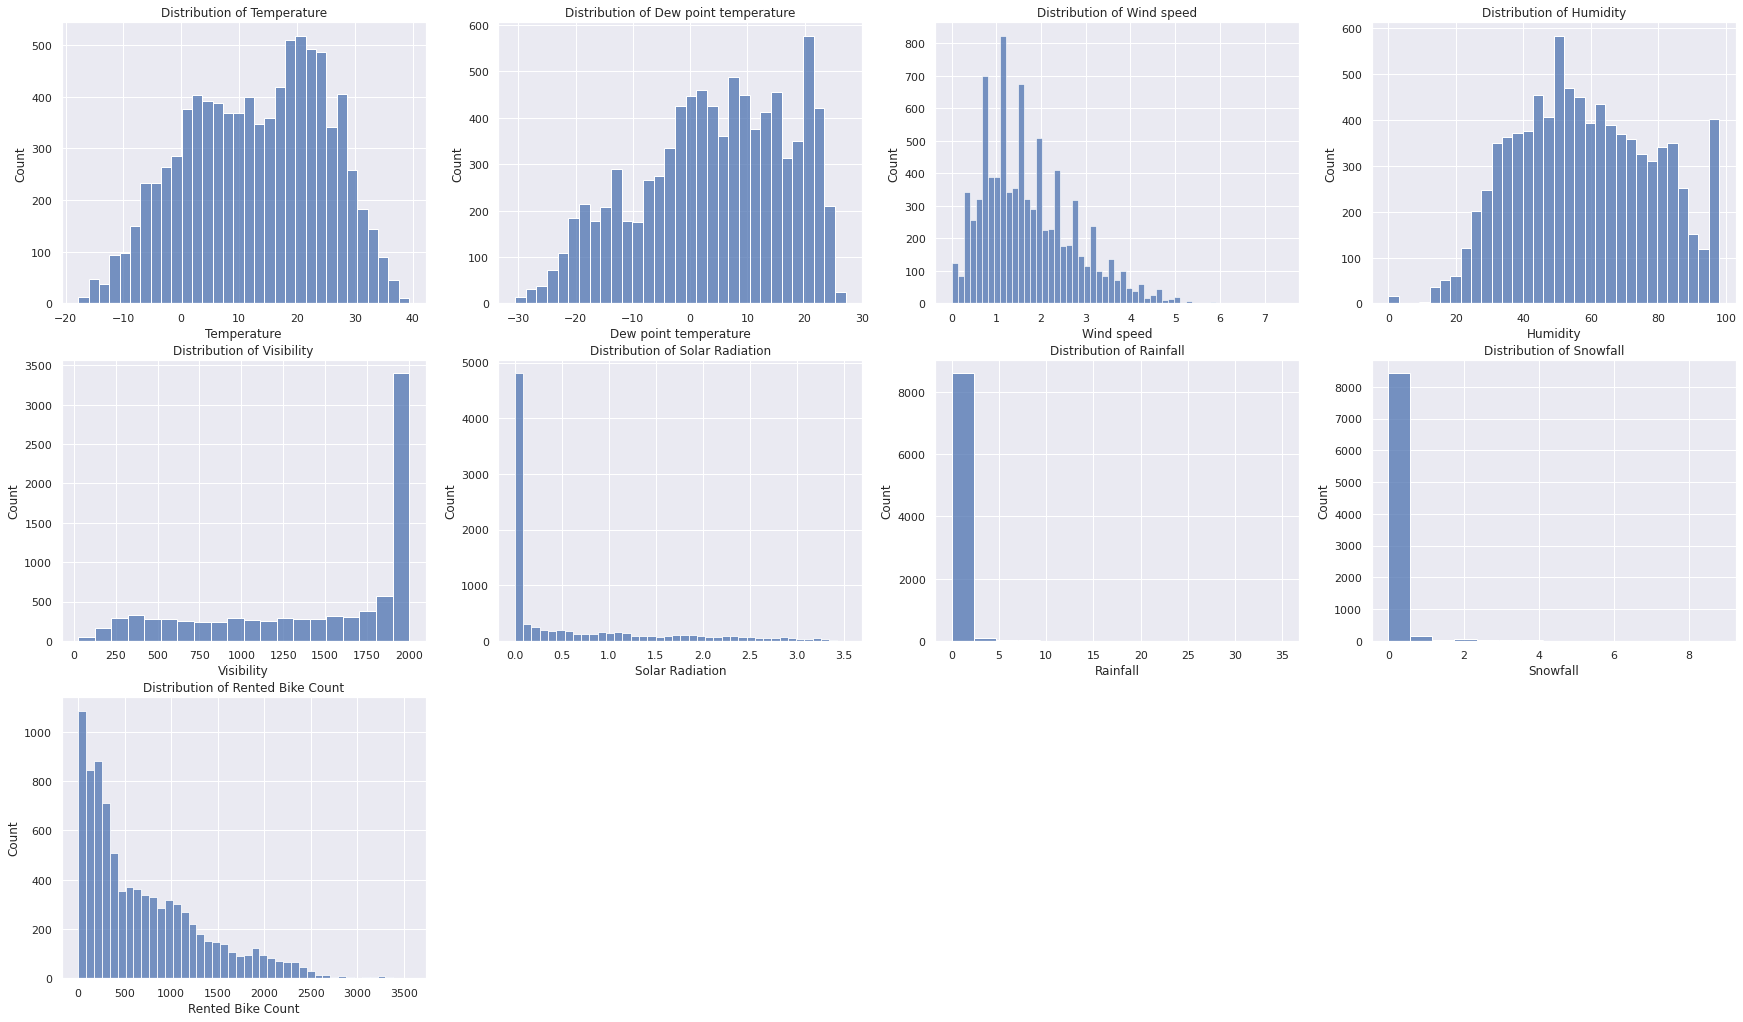

In [ ]:
fig = plt.figure(figsize=(30, 30))
for i, col in enumerate(distrib_columns):
  plt.subplot(5, 4, i+1)
  sns.histplot(x=col, data=dataset).set(
      title=f"Distribution of {col}")

plt.show()

Allows to know the number of "No" response in the data

In [ ]:
dataset["Functioning Day"].value_counts()

Yes    8465
No      295
Name: Functioning Day, dtype: int64

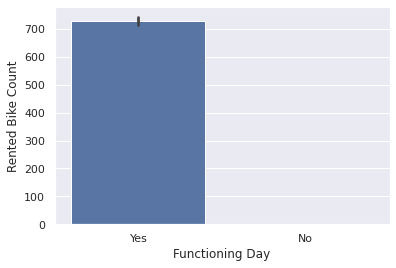

In [ ]:
sns.barplot(data=dataset, x="Functioning Day", y="Rented Bike Count")
plt.show()

In [ ]:
dataset[["Functioning Day", "Rented Bike Count"]].groupby(["Functioning Day"]).sum()

,Rented Bike Count
Functioning Day,
No,0
Yes,6172314


We can see that when the ```Functioning Day``` is "No", there is 0 Rented Bike for the day. So we can drop the variable.

## Feature Engineering

Added the feature ```Special Day```. It give us more information on off-days in Korea (Seoul)

In [ ]:
dict_special_days={
                   "01/01/2017":"New Year's Day",
                   "01/03/2017":"Independence Movement Day",
                   "05/05/2017":"Children's Day",
                   "06/06/2017":"Memorial Day",
                   #"17/07/2017":"Constitution Day",
                   "15/08/2017":"Liberation Day",
                   "03/10/2017":"National Foundation Day",
                   "09/10/2017":"Hangul Day",
                   "25/12/2017":"Christmas",
                   "04/10/2017":"Chuseok",
                   "05/10/2017":"Chuseok",
                   "06/10/2017":"Chuseok",
                   "03/05/2017":"Buddha's Birthday",
                   "28/01/2017":"Lunar New Year's Day",
                   "29/01/2017":"Lunar New Year's Day",
                   "30/01/2017":"Lunar New Year's Day",  
                   "01/01/2018":"New Year's Day",
                   "01/03/2018": "Independence Movement Day",
                   "05/05/2018":"Children's Day",
                   "06/06/2018":"Memorial Day",
                   #"17/07/2018":"Constitution Day",
                   "15/08/2018":"Liberation Day",
                   "03/10/2018":"National Foundation Day",
                   "09/10/2018":"Hangul Day",
                   "25/12/2018":"Christmas",
                   "24/09/2018":"Chuseok",
                   "25/09/2018":"Chuseok",
                   "26/09/2018":"Chuseok",
                   "22/05/2018":"Buddha's Birthday",
                   "16/02/2018":"Lunar New Year's Day",
                   "17/02/2018":"Lunar New Year's Day",
                   "18/02/2018":"Lunar New Year's Day"
}

In [ ]:
dataset["Special Day"] = dataset["Date"].map(dict_special_days)
dataset["Special Day"] = dataset["Special Day"].fillna("Normal Day")
dataset["Special Day"] = dataset["Special Day"].apply(lambda x: 0 if x == "Normal Day" else 1)

```Felt temperature``` uses a mathematical formula to determine the felt temperature.

In [ ]:
#dataset["Felt temperature"] = 13.2 + 0.6215 * dataset["Temperature"] + (0.3965 * dataset["Temperature"] - 11.37) * (dataset["Wind speed"]/3.6) ** 0.16

We saw on the distributions plots, that ```Rainfall``` and ```Snowfall``` have a lot of 0 values, so we use them to create ```Ground quality``` which gives us an indication on the ground quality (slippery or not). 

In [ ]:
dataset["Ground quality"] = (dataset["Rainfall"] == 0) & (dataset["Snowfall"] == 0)
dataset["Ground quality"] = dataset["Ground quality"].map({True:1, False:0})

Add the daily ```O3``` measurement to our dataset

In [ ]:
dataset["O3"] = dataset["Date"].map(pollution_dict)

Use the month in the column ```Date``` to create a new feature ```Month```

In [ ]:
dataset["Date"] = pd.to_datetime(dataset["Date"])

In [ ]:
dataset["Month"] = dataset["Date"].apply(lambda x: x.month)

Use the feature ```Date``` to create a new feature called ```WeekEnd```

In [ ]:
dataset["Day"] = dataset["Date"].apply(lambda x: x.weekday())

In [ ]:
dataset["WeekEnd"] = dataset["Day"].apply(lambda x: 1 if x >= 5 else 0)

Add a feature which tells us if its a ```Holiday``` day or not

In [ ]:
dataset["Holiday"] = dataset["Holiday"].map({"No Holiday":0,"Holiday":1})

We Keep the row only if this a functioning day else we know that the ```Rented Bike Count``` is 0

In [ ]:
dataset.drop(dataset[dataset["Functioning Day"] == "No"].index, inplace=True)

In [ ]:
dataset.drop("Functioning Day", axis = 1, inplace=True)

Show the changes in the dataset

In [ ]:
dataset.head()

,Date,Hour,Temperature,Dew point temperature,Wind speed,Humidity,Visibility,Solar Radiation,Rainfall,Snowfall,Seasons,Holiday,Rented Bike Count,Special Day,Ground quality,O3,Month,Day,WeekEnd
0,2017-01-12,0,-5.2,-17.6,2.2,37,2000,0.0,0.0,0.0,Winter,0,254,0,1,0.011667,1,3,0
1,2017-01-12,1,-5.5,-17.6,0.8,38,2000,0.0,0.0,0.0,Winter,0,204,0,1,0.011667,1,3,0
2,2017-01-12,2,-6.0,-17.7,1.0,39,2000,0.0,0.0,0.0,Winter,0,173,0,1,0.011667,1,3,0
3,2017-01-12,3,-6.2,-17.6,0.9,40,2000,0.0,0.0,0.0,Winter,0,107,0,1,0.011667,1,3,0
4,2017-01-12,4,-6.0,-18.6,2.3,36,2000,0.0,0.0,0.0,Winter,0,78,0,1,0.011667,1,3,0


Here we want to see the correlations between the variables and the target

In [ ]:
scatter_columns = list(dataset.columns)
scatter_columns.remove("Rented Bike Count")

So we plot the scatterplots of each variable vs the ```Rented Bike Count```

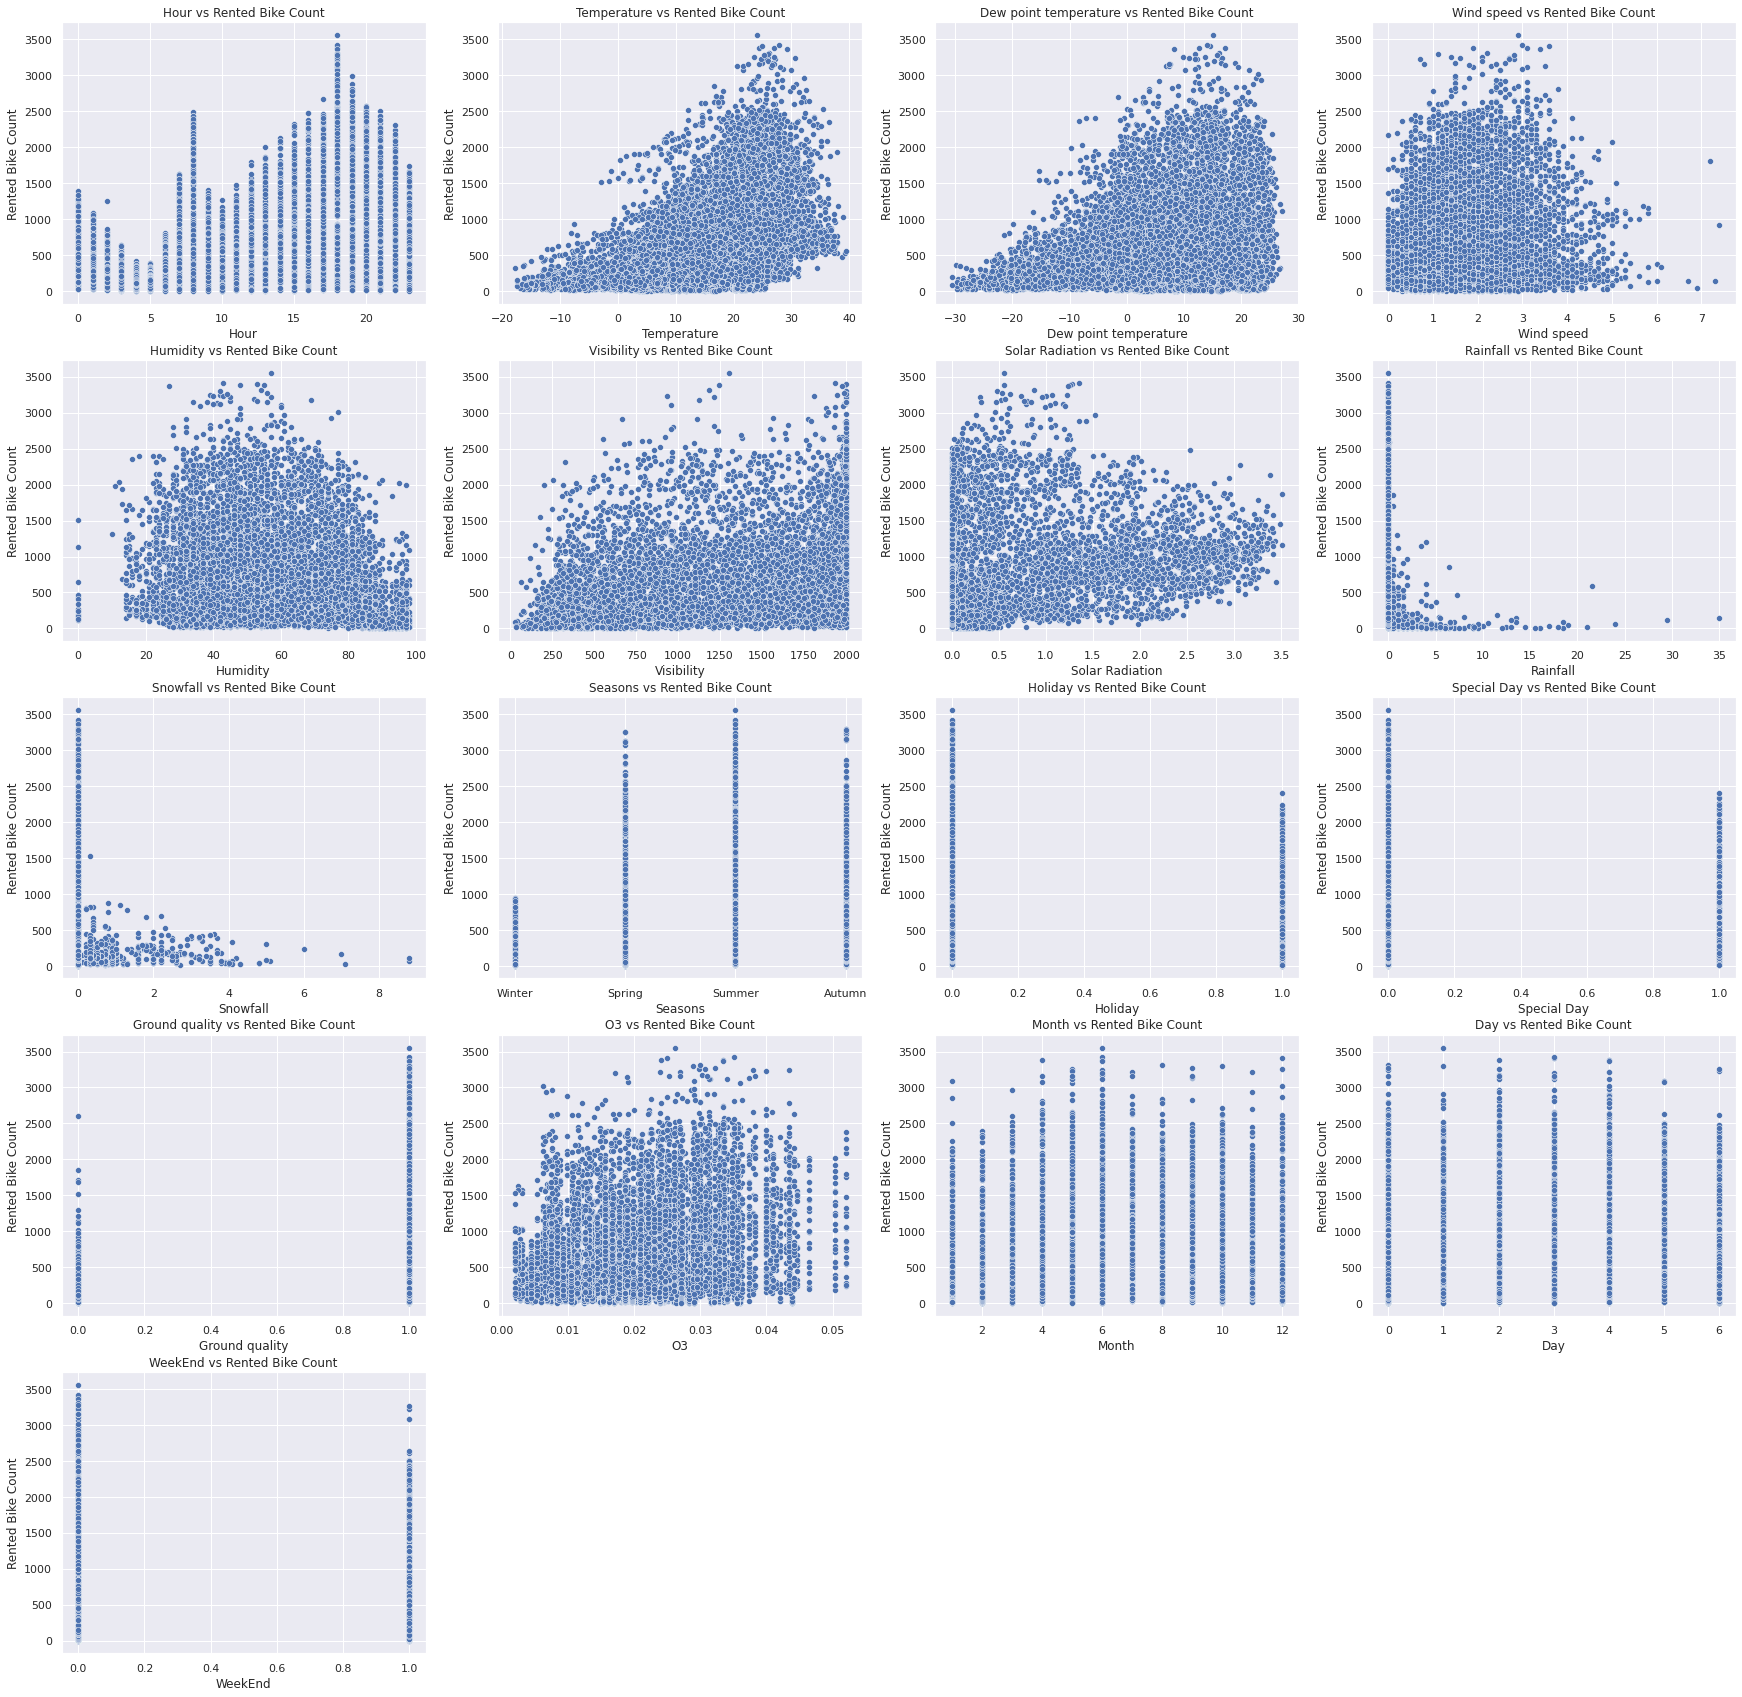

In [ ]:
fig = plt.figure(figsize=(30, 30))
for i, col in enumerate(scatter_columns[1:]):
  plt.subplot(5, 4, i+1)
  sns.scatterplot(x=col, y="Rented Bike Count", data=dataset).set(
      title=f"{col} vs Rented Bike Count")

plt.show()

The ```O3``` variable is Daily but the ```Rented Bike Count``` depends also of the hour. So we compute the mean of the ```Rented Bike Count``` by day to compare them. 

In [ ]:
dataset_O3_Rented_Bike = dataset[["Date", "O3", "Rented Bike Count"]].copy()
dataset_O3_Rented_Bike["Rented Bike Count"] = dataset_O3_Rented_Bike["Date"].map(dataset_O3_Rented_Bike.groupby("Date").mean()["Rented Bike Count"])

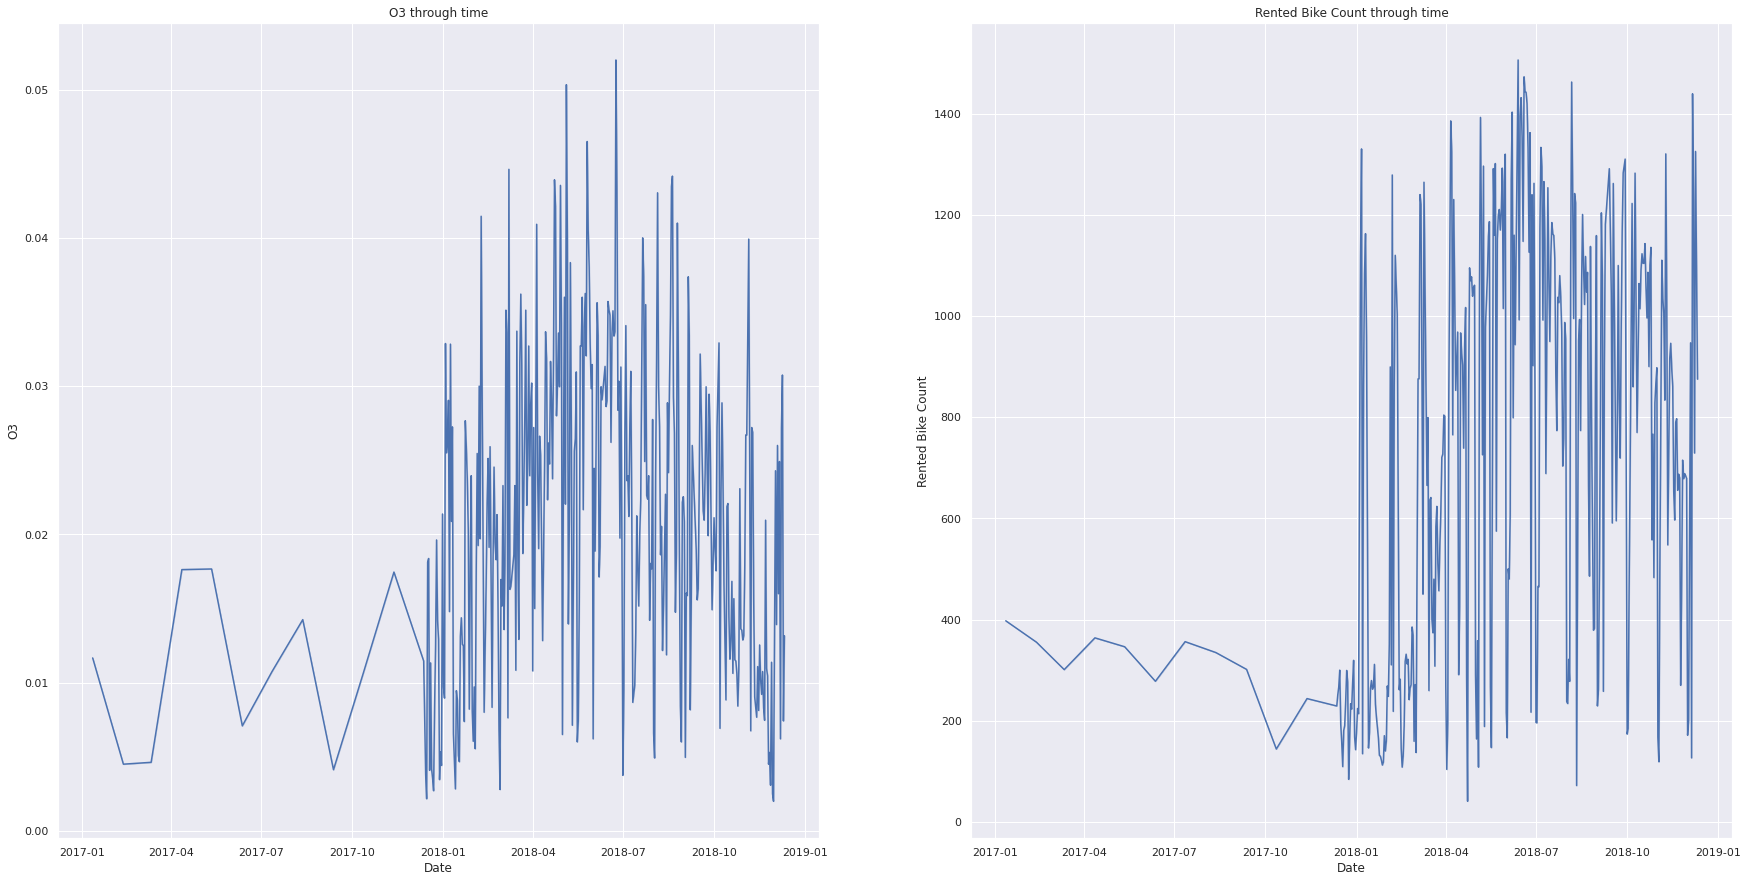

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(30, 15))

sns.lineplot(data=dataset_O3_Rented_Bike, x="Date", y="O3", ax=ax1).set(title="O3 through time")
sns.lineplot(data=dataset_O3_Rented_Bike, x="Date", y="Rented Bike Count", ax=ax2).set(title="Rented Bike Count through time")

plt.show()

We can see some similitude between the two plots through time.

We drop the ```Date``` because because we don't need it anymore.

In [ ]:
dataset.drop("Date", axis = 1, inplace=True)

Know we can see the correlations between the variables with a heatmap

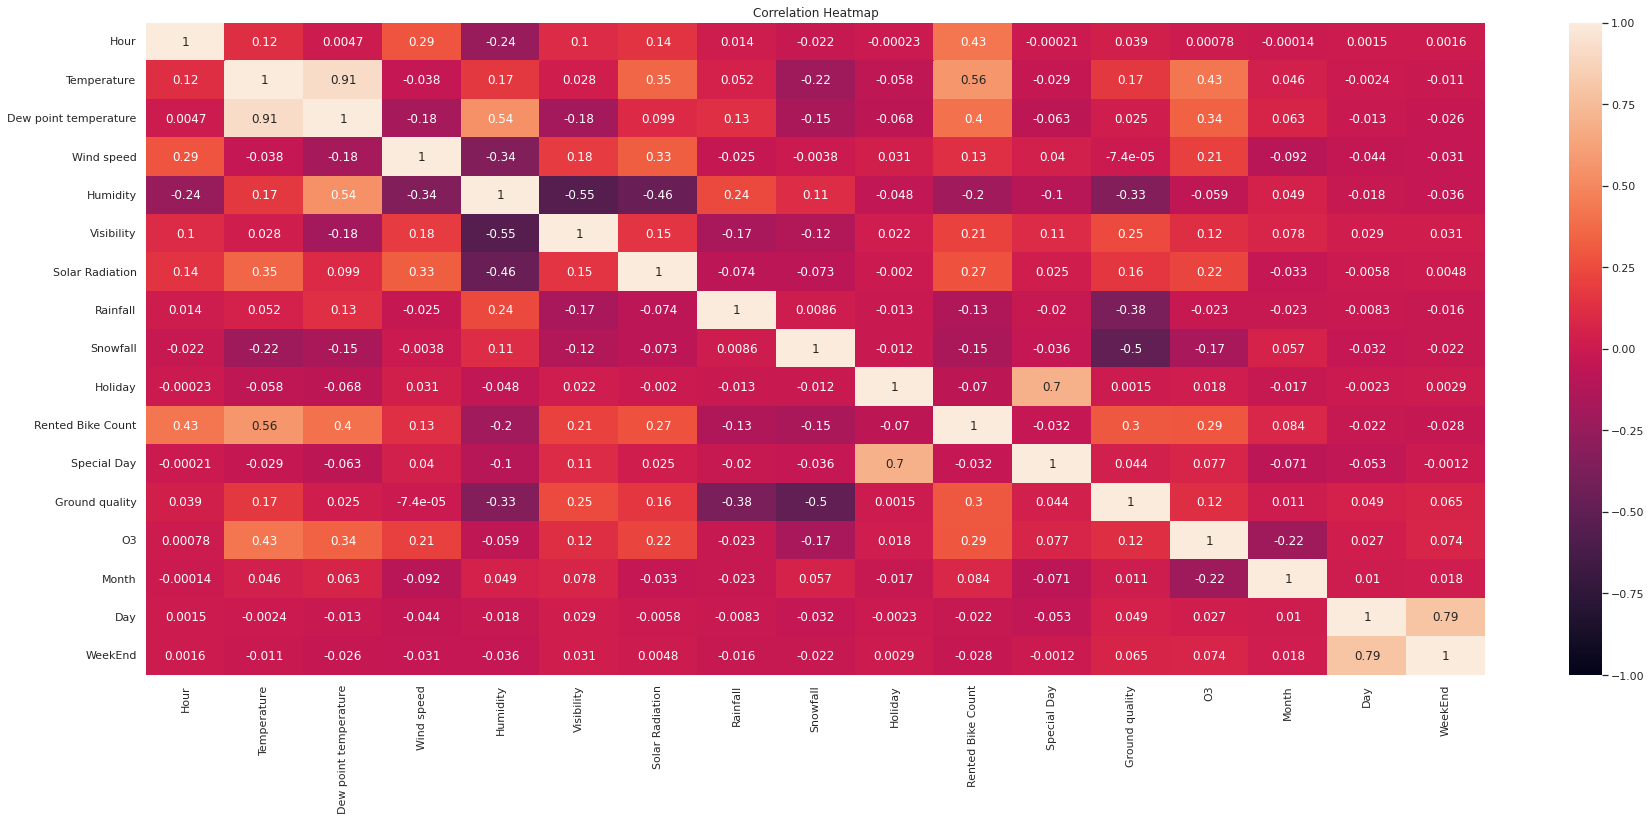

In [ ]:
plt.figure(figsize=(30, 12))
sns.heatmap(dataset.corr(), vmin=-1, vmax=1, annot=True).set(title='Correlation Heatmap')
plt.show()

We can see that the ```Temperature```, the ```Hour```, the ```Dew Point Temperature``` have good correlation with the ```Rented Bike Count```.

#### One-hot encoding of the categorical columns

In [ ]:
dataset = pd.get_dummies(dataset)

## Separate the target and the features

In [ ]:
X = dataset.drop("Rented Bike Count", axis=1)
y = dataset["Rented Bike Count"]

In [ ]:
from sklearn.feature_selection import mutual_info_regression

mi_scores = mutual_info_regression(X, y, random_state=1)
mi_scores = pd.Series(mi_scores, index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)
mi_scores

Temperature              0.376626
Hour                     0.369425
Seasons_Winter           0.206097
Solar Radiation          0.199945
Dew point temperature    0.195522
O3                       0.178456
Month                    0.114969
Humidity                 0.107178
Ground quality           0.103847
Rainfall                 0.074637
Seasons_Summer           0.062904
Visibility               0.058260
Snowfall                 0.047372
Seasons_Autumn           0.032130
Wind speed               0.020458
WeekEnd                  0.008445
Holiday                  0.006105
Day                      0.003293
Seasons_Spring           0.002964
Special Day              0.000000
dtype: float64

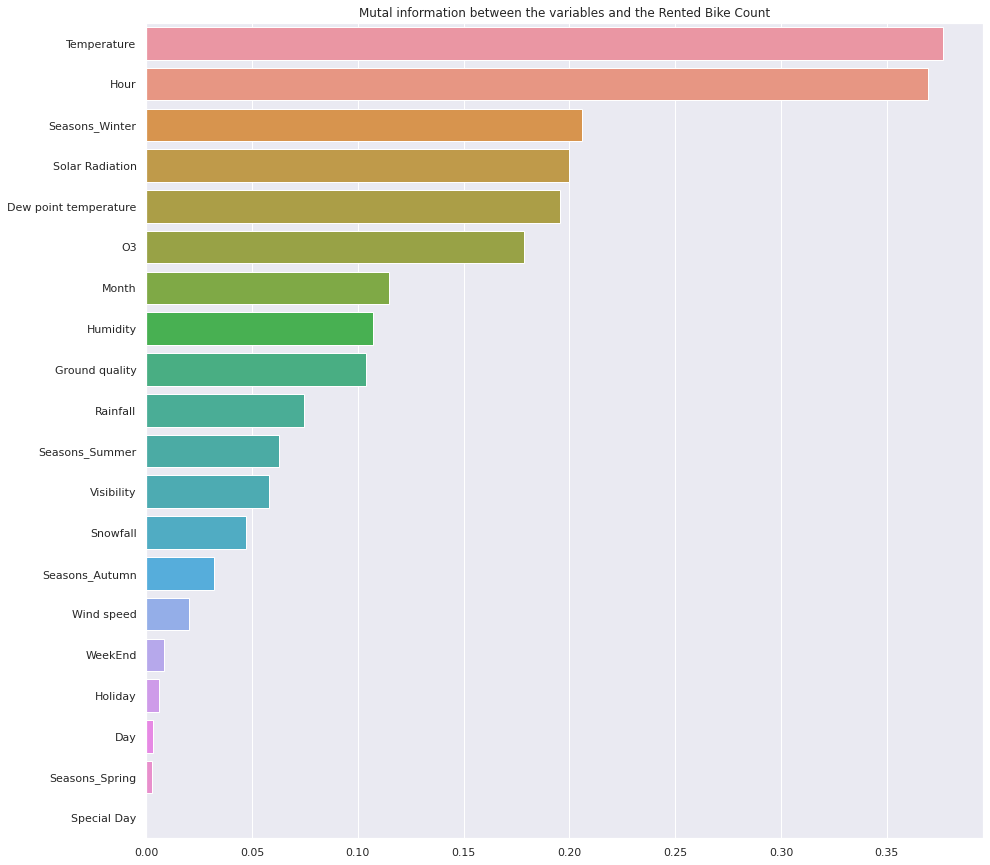

In [ ]:
plt.figure(figsize = (15, 15))
sns.barplot(y=mi_scores.index,x=mi_scores.values).set(title="Mutal information between the variables and the Rented Bike Count")
plt.show()

The mutual information (MI) quantifies the "amount of information" obtained about one random variable by observing the other. Its an important information for feature selection.

## Dataset scoring

We will try to do some analysis here to see if the columns that we want to drop will really improve our predictions.

In [ ]:
def score_dataset(X, y):
  model = DecisionTreeRegressor(random_state=1)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
  model.fit(X_train, y_train)
  return mean_squared_error(y_test, model.predict(X_test))

In [ ]:
cols_to_drop = ["Holiday", "Special Day", "Day", "WeekEnd", "Wind speed", "Month"]

In [ ]:
first_scores = pd.Series({col:score_dataset(X.drop(col ,axis=1), y) for col in cols_to_drop})
first_scores.sort_values(ascending=False)

Month          92629.249410
Day            87205.170997
Special Day    85505.954653
Holiday        83105.350496
WeekEnd        83026.638167
Wind speed     80968.380255
dtype: float64

In [ ]:
score_dataset(X, y) # without droping any variables

85346.56353330184

We can see that when we drop ```Wind speed```, we have the lowest error.

We can also try to drop the ```Wind speed``` and another variable with the same technique and see the results.

In [ ]:
second_scores = pd.Series({col:score_dataset(X.drop(["Wind speed", col], axis=1), y) for col in cols_to_drop})
second_scores.sort_values(ascending=False)

Month          87420.399622
Day            86869.103448
Special Day    84971.863958
WeekEnd        83714.701937
Wind speed     80968.380255
Holiday        79922.571564
dtype: float64

We see that we can also drop the ```Holiday``` to minimise the error.

In [ ]:
X.drop(["Wind speed", "Holiday"], axis=1, inplace=True)

## Create train and test set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

## Datas scaling

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
st_scaler = StandardScaler()

X_train_scaled = pd.DataFrame(st_scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(st_scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [ ]:
min_max_scaler = MinMaxScaler()

X_train_scaled = pd.DataFrame(min_max_scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(min_max_scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

With few tests, we can see that there is not a big difference if we use the StandardScaler or the MinMaxScaler. We chose the StandardScaler.

## Hyperparameters optimization

Create a grid search for the optimiztion of the hyperparameters

In [ ]:
def grid_search_best_parameters(model, parameters, X_train, y_train):
  grid_search = GridSearchCV(model, parameters, scoring="r2", cv=4, verbose=0)
  grid_search.fit(X_train, y_train)
  return grid_search.best_estimator_, grid_search.best_score_, grid_search.best_params_

Optimization for the Random Forest

In [ ]:
rfr_grid_test = RandomForestRegressor(random_state=1)

In [ ]:
rfr_grid_params = {
    "n_estimators": [400, 500, 600, 700, 800],
    "min_samples_split":[2, 3],
    "criterion": ["squared_error", "absolute_error", "poisson"]
}

In [ ]:
grid_search_best_parameters(rfr_grid_test, rfr_grid_params, X_train_scaled, y_train)

Optimization for the Xtreme Gradient Boosting

In [ ]:
xgbr_grid_params = {
    "n_estimators": [650, 700, 750, 800, 850],
    "learning_rate": [0.025, 0.035, 0.045, 0.05],
    "max_depth":[5, 7]
}

In [ ]:
xgbr_grid_test = XGBRegressor(random_state=1, verbosity=0)

In [ ]:
grid_search_best_parameters(xgbr_grid_test, xgbr_grid_params, X_train_scaled, y_train)

(XGBRegressor(learning_rate=0.045, max_depth=7, n_estimators=850, random_state=1,
              verbosity=0),
 0.9214228221134333,
 {'learning_rate': 0.045, 'max_depth': 7, 'n_estimators': 850})

## Models Testing

Create a method that allow to plot the errors and show some statistics about the model prediction errors.

In [ ]:
def plot_errors(y_true, y_pred, ax=None):
  plt.figure(figsize=(15, 12))
  errors = y_true-y_pred
  if ax:
    sns.histplot(x=errors, ax=ax).set(title="Model predictions errors")
  else:
    sns.histplot(x=errors).set(title="Model predictions errors")
  return pd.Series(errors, name="Prediction error stats").describe()

Our goal is to have the most centered representation (mean = 0) and the minimum variance.

### Decision Tree Model

In [ ]:
dtr = DecisionTreeRegressor(random_state=1)
dtr.fit(X_train_scaled, y_train)
dtr.score(X_test_scaled, y_test)

#_ = plot_tree(model, feature_names=X_train_scaled.columns, filled=True)

0.809243703953952

In [ ]:
dtr_y_pred = np.round(dtr.predict(X_test_scaled))

In [ ]:
r2_score(y_test, dtr_y_pred)

0.809243703953952

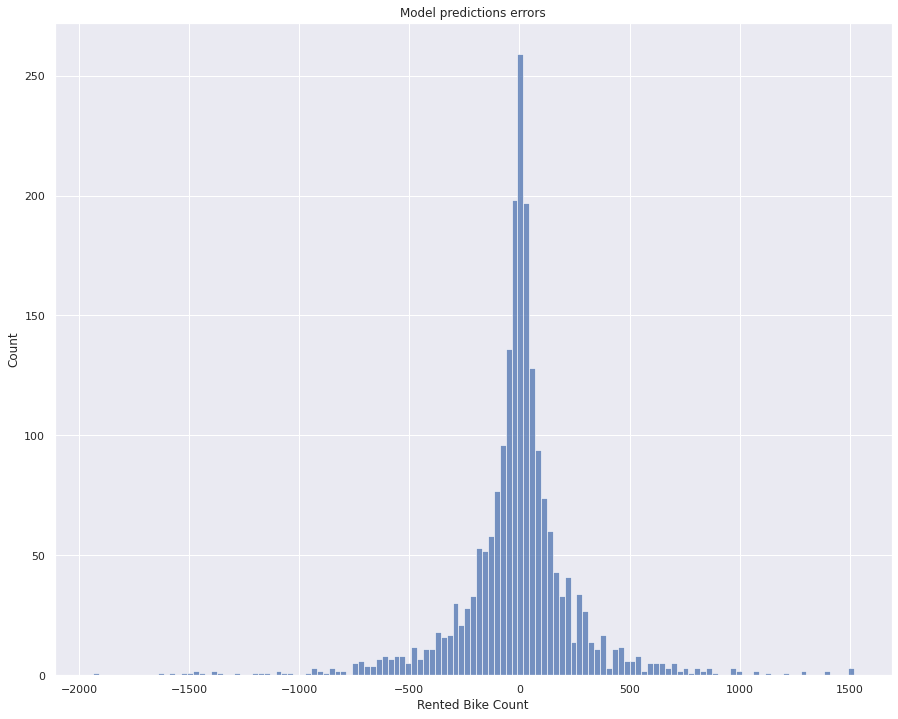

In [ ]:
predictions_errors_stats = plot_errors(y_test, dtr_y_pred)

The stats give us some additional informations about the plot

In [ ]:
predictions_errors_stats

count    2117.000000
mean      -11.873406
std       283.403735
min     -1938.000000
25%       -93.000000
50%        -1.000000
75%        80.000000
max      1518.000000
Name: Prediction error stats, dtype: float64

### Random Forest Model

In [ ]:
rfr = RandomForestRegressor(n_estimators=400, random_state=1)
rfr.fit(X_train_scaled, y_train)
rfr.score(X_test_scaled, y_test)

0.8966822292108064

In [ ]:
rfr_y_pred = np.round(rfr.predict(X_test_scaled))

In [ ]:
r2_score(y_test, rfr_y_pred)

0.896682234566528

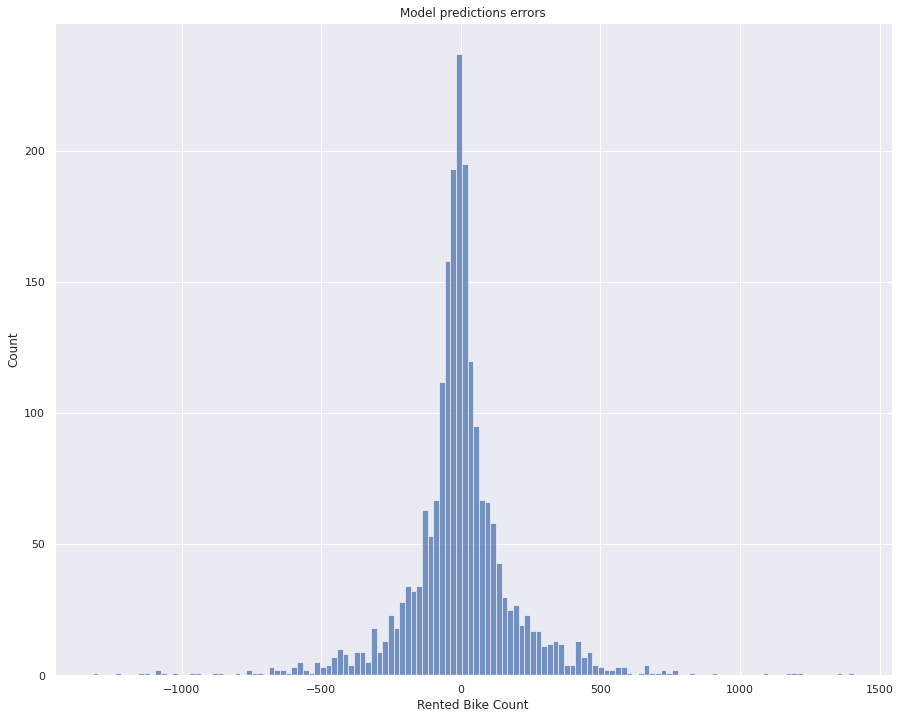

In [ ]:
predictions_errors_stats = plot_errors(y_test, rfr_y_pred)

The stats give us some additional informations about the plot

In [ ]:
predictions_errors_stats

count    2117.000000
mean       -6.431271
std       208.654775
min     -1319.000000
25%       -70.000000
50%        -8.000000
75%        61.000000
max      1407.000000
Name: Prediction error stats, dtype: float64

### Xtreme Gradient Boosting Model

In [ ]:
xgbr = XGBRegressor(n_estimators=850, learning_rate=0.045, max_depth=7, random_state=1, verbosity=0)
xgbr.fit(X_train_scaled, y_train)
xgbr.score(X_test_scaled, y_test)

0.921627274089508

In [ ]:
xgbr_y_pred = np.round(xgbr.predict(X_test_scaled))

In [ ]:
r2_score(y_test, xgbr_y_pred)

0.9216155922826909

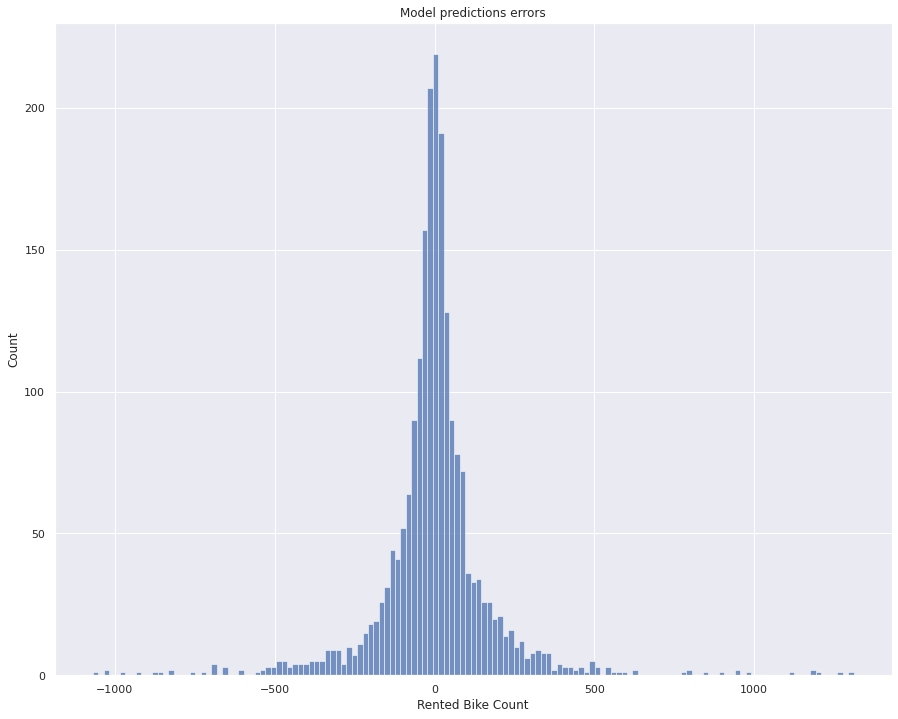

In [ ]:
predictions_errors_stats = plot_errors(y_test, xgbr_y_pred)

The stats give us some additional informations about the plot

In [ ]:
predictions_errors_stats

count    2117.000000
mean       -0.944261
std       181.826050
min     -1069.000000
25%       -56.000000
50%        -1.000000
75%        53.000000
max      1311.000000
Name: Prediction error stats, dtype: float64

## Deep Neural Network

Here, our goal is to create a Neural Network that best fits with our datas.

In [ ]:
input_shape = [X_train_scaled.shape[1]]

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),                     

    layers.Dense(512, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(1)
])

We tried few combinations for the creation of the NN. We tried to add more layers, or to change the number of units by layers. The solution we write upper was the best.

In [ ]:
model.compile(
    optimizer="adam",
    loss="mse"
)

Here we create an object that will allow us to stop the iterations of the model if there is no improvements. It allow to avoid overfitting.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=20,
    restore_best_weights=True
)

We intentionally set the epochs to a high number because the early_stopping will stop the training before.

In [ ]:
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=1000,
    batch_size=256,
    callbacks=[early_stopping],
)

Epoch 1/1000
25/25 [==============================] - 2s 33ms/step - loss: 917679.5625 - val_loss: 974740.3125
Epoch 2/1000
25/25 [==============================] - 1s 23ms/step - loss: 902316.3750 - val_loss: 977706.7500
Epoch 3/1000
25/25 [==============================] - 1s 23ms/step - loss: 890683.9375 - val_loss: 983159.3750
Epoch 4/1000
25/25 [==============================] - 1s 24ms/step - loss: 878020.6875 - val_loss: 977137.3125
Epoch 5/1000
25/25 [==============================] - 1s 23ms/step - loss: 864159.1250 - val_loss: 973268.4375
Epoch 6/1000
25/25 [==============================] - 1s 23ms/step - loss: 848251.2500 - val_loss: 963514.5000
Epoch 7/1000
25/25 [==============================] - 1s 23ms/step - loss: 830959.8750 - val_loss: 971106.9375
Epoch 8/1000
25/25 [==============================] - 1s 24ms/step - loss: 812610.5625 - val_loss: 956438.3750
Epoch 9/1000
25/25 [==============================] - 1s 23ms/step - loss: 792535.5000 - val_loss: 947893.5000
E

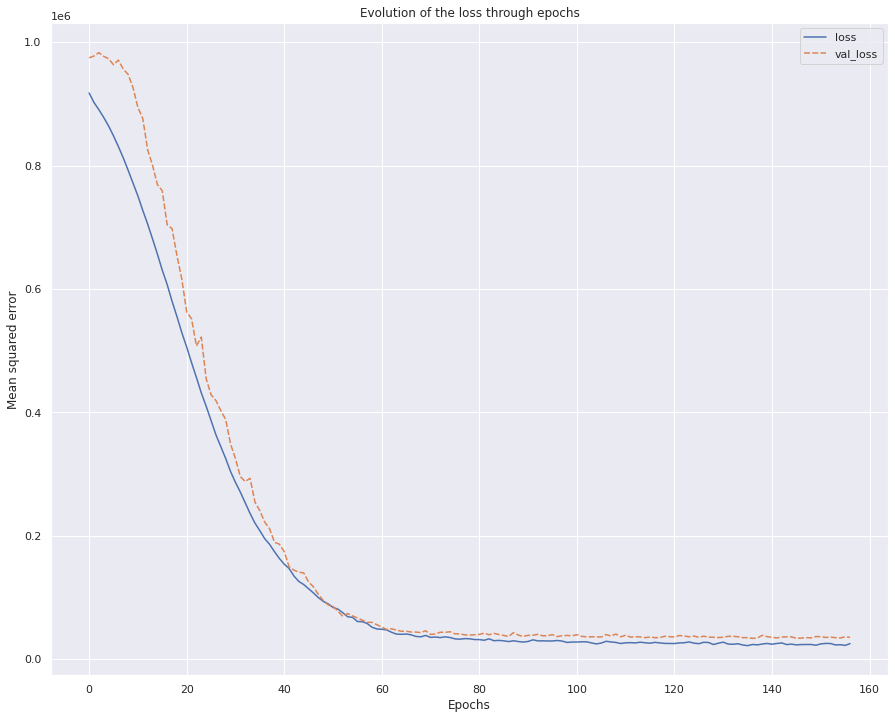

In [ ]:
fig = plt.figure(figsize=(15, 12))
sns.lineplot(data = pd.DataFrame(history.history)).set(
    title="Evolution of the loss through epochs",
    xlabel = "Epochs", ylabel = "Mean squared error")
plt.show()

## Comparaison Neural Network et Machine Learning

In [ ]:
model.evaluate(X_test_scaled, y_test, verbose=2)

67/67 - 0s - loss: 33860.6797 - 125ms/epoch - 2ms/step


33860.6796875

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mean_squared_error(xgbr.predict(X_test_scaled), y_test)

33041.06232735536

In [ ]:
y_pred = np.round(model.predict(X_test_scaled))

In [ ]:
y_pred = np.array([x[0] for x in y_pred])

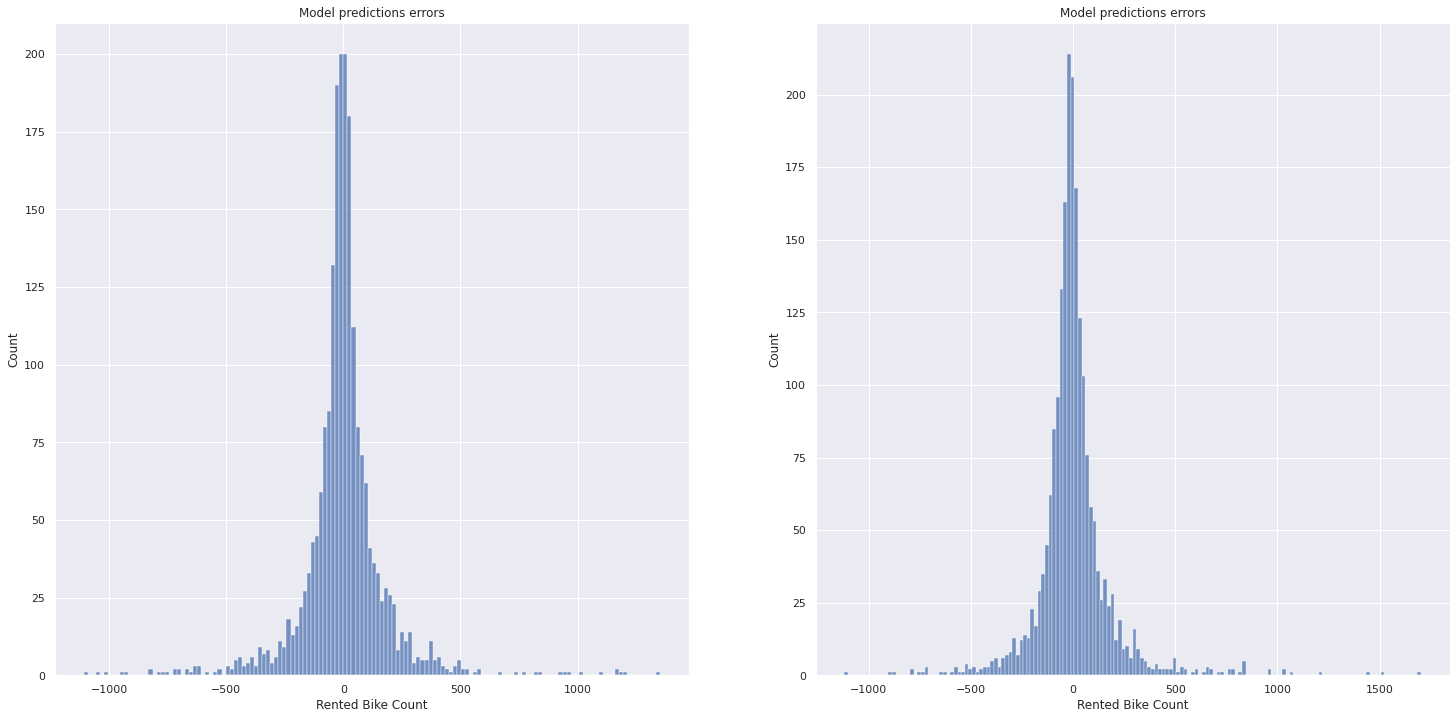

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

In [ ]:
fig, (axx1, axx2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 12))

plot_errors(y_test, xgbr_y_pred, axx1)
predictions_errors_stats = plot_errors(y_test, y_pred, axx2)

plt.show()

In [ ]:
predictions_errors_stats

count    2117.000000
mean        0.531885
std       184.057481
min     -1120.000000
25%       -65.000000
50%       -11.000000
75%        50.000000
max      1702.000000
Name: Prediction error stats, dtype: float64

When we compare the stats and the plots, we see that the XGB model is still the best, even if there close. We probably should have a better Neural Network if we had more datas.